In [2]:
import pandas as pd
import zipfile
import seaborn as sn
import re
import string

In [3]:
pd.set_option('display.max_columns', 50)

In [4]:
def read_zip_file(zip_handler, file_name: str, headers: list[str]) -> pd.DataFrame:
    """Creates dataframe from the given file in zip"""
    with zip_handler.open(file_name, 'r') as data:
        temp_df = pd.read_csv(data, names = HEADERS, sep=',')
    return temp_df

In [5]:
def merge_data_files_from_zip(zip_file: str, headers: list[str], except_files=[]) -> pd.DataFrame:
    """Creates dataframe that contains data from all files"""
    final_df = pd.DataFrame()
    with zipfile.ZipFile(zip_file) as my_zip:
        all_files = my_zip.namelist()
        for name in all_files:
            if name not in except_files:
                temp_df = read_zip_file(my_zip, name, headers)
                
                year = int(re.findall(r'\d+', name)[0])
                temp_df['year'] =  [year] * temp_df.shape[0]
                
                final_df = pd.concat([final_df, temp_df], copy=True) #copy???
    return final_df

In [6]:
file_path = 'babynames.zip'

In [7]:
HEADERS = ['name', 'gender', 'count']
df = merge_data_files_from_zip(file_path, HEADERS, ['babynames/NationalReadMe.pdf'])

In [8]:
df.shape

(1690784, 4)

In [370]:
df.head()

,name,gender,count,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [371]:
def get_born_count(original_df: pd.DataFrame) -> pd.DataFrame:
    "Creates dataframe with count of born children in every year"
    return (original_df.groupby(['year']).
            agg({'count' : sum}))

In [372]:
born_count = get_born_count(df)

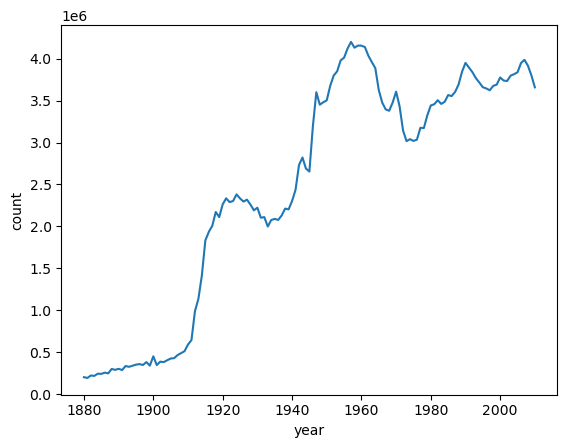

In [373]:
born_plot = sn.lineplot(born_count, x='year', y='count')

### A) Доля имени

In [374]:
def get_names_count(original_df: pd.DataFrame) -> pd.DataFrame:
    """Creates dataframe that shows number of people with this name"""
    return (original_df.groupby(['name'], as_index=False)
            .agg({'count' : sum})
            .sort_values(by='count', ascending=False)
            .reset_index(drop=True))

In [375]:
names_count = get_names_count(df)
names_count.head()

,name,count
0,James,5072771
1,John,5061897
2,Robert,4788050
3,Michael,4265373
4,Mary,4119074


In [492]:
def get_name_proportion(original: pd.DataFrame, name: str) -> pd.DataFrame:
    """Counts proportion of given name in total set of names"""
    names_count = get_names_count(original)
    
    children_total = names_count['count'].sum()
    
    children_with_this_name = names_count.query("name == @name").reset_index(drop=True)
    children_with_this_name['proportion'] = children_with_this_name['count'].values / children_total
    return children_with_this_name

In [493]:
get_name_proportion(df, 'John')

,name,count,proportion
0,John,5061897,0.015701


### B) Относительный ранг имени

In [441]:
def get_name_rank(original: pd.DataFrame, name) -> pd.DataFrame:
    """Shows what rank the given name have"""
    names_count = get_names_count(original)
    names_count['rank'] = names_count['count'].rank()
    return names_count.query("name == @name").reset_index(drop=True)

In [442]:
get_name_rank(df, 'Anastasia')

,name,count,rank
0,Anastasia,33235,87313.0


### C) Поиск самых популярных и быстрорастущих имён в каждом году (если одним именем называют, как мальчиков, так и девочек, то считаются ли эти имена разными или одинаковыми? )

In [497]:
def get_year_most_popular_name(original: pd.DataFrame, ignore_gender=False) -> pd.DataFrame:
    """
    Function shows the most popular name for every year, and it's appear count
    
    Args:
        ignore_gender (bool) - set true, if you don't want to separate names by gender
    """
    if ignore_gender:
        original = original.groupby(['name', 'year'], as_index=False).agg({'count' : 'sum'})
    
    max_count_in_year = original.groupby(['year']).agg({'count' : 'max'})
    most_popular_names = max_count_in_year.merge(original, how='inner', on=['year', 'count'])
    
    COLS = ['year', 'name', 'count']
    if not ignore_gender:
        COLS.insert(2, 'gender')

    return most_popular_names[COLS]


In [498]:
get_year_most_popular_name(df)

,year,name,gender,count
0,1880,John,M,9655
1,1881,John,M,8769
2,1882,John,M,9557
3,1883,John,M,8894
4,1884,John,M,9387
...,...,...,...,...
126,2006,Jacob,M,24797
127,2007,Jacob,M,24216
128,2008,Jacob,M,22507
129,2009,Isabella,F,22222


In [499]:
get_year_most_popular_name(df, True)

,year,name,count
0,1880,John,9701
1,1881,John,8795
2,1882,John,9597
3,1883,John,8934
4,1884,John,9427
...,...,...,...
126,2006,Jacob,24834
127,2007,Jacob,24250
128,2008,Jacob,22536
129,2009,Isabella,22248


In [383]:
def get_most_popularity_change(original: pd.DataFrame, func='max') -> pd.DataFrame:
    """
    Creates dataframe that shows names with biggest change in popularity
    
    Args:
        func (str) - function for selecting difference in every year
    """
    df_without_gender = original.groupby(['name', 'year'], as_index=False).agg({'count': 'sum'})
    
    # Diffrence in every name usage.
    df_without_gender['diff'] = df_without_gender.groupby(['name']).agg({'count': 'diff'})
    
    # Biggest name usage difference in every year. 
    year_max_rise = df_without_gender.groupby(['year'], as_index=False).agg({'diff': func}).dropna()
    
    # Adding names
    max_rised_name = pd.merge(year_max_rise, df_without_gender, how='inner', on=['year', 'diff'])
    
    return max_rised_name[['year', 'name', 'diff']]

In [384]:
get_most_popularity_change(df).head(10)

,year,name,diff
0,1881,Ethel,154.0
1,1882,Mary,1231.0
2,1883,Anna,179.0
3,1884,Mary,1209.0
4,1885,Helen,154.0
5,1886,Mary,757.0
6,1887,Ethel,212.0
7,1888,Mary,1869.0
8,1889,Ruth,223.0
9,1890,Mary,423.0


In [385]:
get_most_popularity_change(df, 'min').head(10)

,year,name,diff
0,1881,William,-1009.0
1,1882,Garfield,-78.0
2,1883,William,-902.0
3,1884,Albert,-67.0
4,1885,William,-854.0
5,1886,Grover,-367.0
6,1887,John,-909.0
7,1888,Dorothea,-24.0
8,1889,William,-928.0
9,1890,William,-290.0


### D) Анализ тенденций состава имён

In [386]:
def is_vowel(letter: str) -> bool:
    """Checks is symbol vowel or not"""
    return (letter == "a" or letter == "e" or letter == "i" or
            letter == "o" or letter == "u" or letter == "y")

In [387]:
def vowel_count(name: str) -> int:
    """Count number of vowels in string"""
    return sum(1 for letter in name if is_vowel(letter))

In [388]:
def consonants_count(name: str) -> int:
    """Count number of consonants in string"""
    return len(name) - vowel_count(name)

In [389]:
def get_names_average_data(x: list[str], func) -> float:
    """Counts average function value on the given list of data"""
    alpha_count = sum(func(name) for name in x.values)
    return alpha_count / len(x)
    

In [390]:
def get_names_symbols_set(x: list[str], index=0) -> list[str]:
    """Creates set of symbols, that are appear in letter on <index> position"""
    symbols = set(name[index] for name in x)
    return list(symbols)

In [391]:
def get_name_tendencies(origin: pd.DataFrame) -> pd.DataFrame:
    """ Creates dataframe that shows specifics of names structure in every year"""
    year_tendencies = (origin.groupby('year', as_index=False)['name'].
                        apply(get_names_average_data, vowel_count).
                        rename(columns={'name': 'vowels'}))
    
    year_tendencies['consonants'] = df.groupby('year')['name'].apply(get_names_average_data, consonants_count).values
    year_tendencies['length'] = df.groupby('year')['name'].apply(get_names_average_data, len).values

    year_tendencies['diffrent_names'] = df.groupby('year').agg({'name': 'count'}).values

    year_tendencies['first_symbols'] = df.groupby('year')['name'].apply(get_names_symbols_set, 0).values
    year_tendencies['last_symbols'] = df.groupby('year')['name'].apply(get_names_symbols_set, -1).values
    return year_tendencies

In [392]:
year_tendencies = get_name_tendencies(df)
year_tendencies

,year,vowels,consonants,length,diffrent_names,first_symbols,last_symbols
0,1880,2.279500,3.420500,5.700000,2000,"[N, Z, G, A, T, E, C, Y, O, M, D, L, V, Q, W, ...","[a, h, z, p, e, r, k, u, g, v, l, w, t, c, y, ..."
1,1881,2.267183,3.407235,5.674419,1935,"[N, Z, G, A, T, E, C, Y, O, M, D, L, V, Q, W, ...","[a, h, z, p, e, r, k, u, g, v, l, w, t, c, y, ..."
2,1882,2.301834,3.422191,5.724024,2127,"[N, Z, G, A, T, E, C, Y, O, M, D, L, V, Q, W, ...","[a, h, z, p, e, r, k, u, g, v, l, w, t, c, y, ..."
3,1883,2.289827,3.407390,5.697217,2084,"[N, Z, G, A, T, E, C, Y, O, M, D, L, V, Q, W, ...","[a, h, z, p, e, r, k, u, g, v, l, w, t, c, y, ..."
4,1884,2.296909,3.419242,5.716152,2297,"[N, Z, G, A, T, E, C, Y, O, M, D, L, V, Q, W, ...","[a, h, z, p, e, r, k, u, g, v, l, w, t, c, y, ..."
...,...,...,...,...,...,...,...
126,2006,2.746879,3.477687,6.224566,34039,"[N, Z, G, A, T, E, X, C, Y, O, M, D, L, V, Q, ...","[a, h, q, z, p, e, r, k, u, g, v, l, w, t, c, ..."
127,2007,2.748903,3.471978,6.220881,34883,"[N, Z, G, A, T, E, X, C, Y, O, M, D, L, V, Q, ...","[a, h, q, z, p, e, r, k, u, g, v, l, w, t, c, ..."
128,2008,2.741102,3.476375,6.217477,35006,"[N, Z, G, A, T, E, X, C, Y, O, M, D, L, V, Q, ...","[a, h, q, z, p, e, r, k, u, g, v, l, w, t, c, ..."
129,2009,2.737587,3.475955,6.213543,34602,"[N, Z, G, A, T, E, X, C, Y, O, M, D, L, V, Q, ...","[a, h, q, z, p, e, r, k, u, g, v, l, w, t, c, ..."


__Анализ изменения среднего количества гласных в словах__

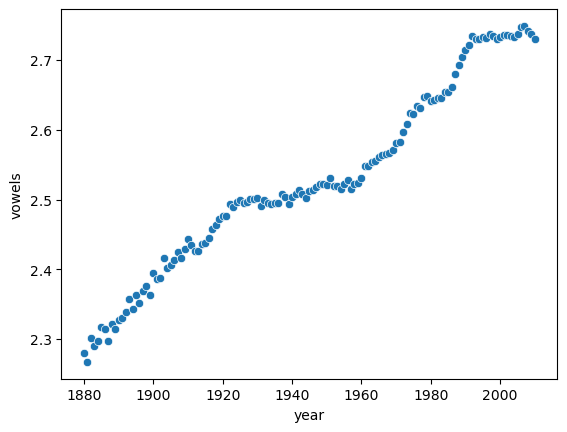

In [393]:
vowels_count_change = sn.scatterplot(data=year_tendencies, x = "year", y = "vowels")

__Анализ изменения среднего количества согласных в словах__

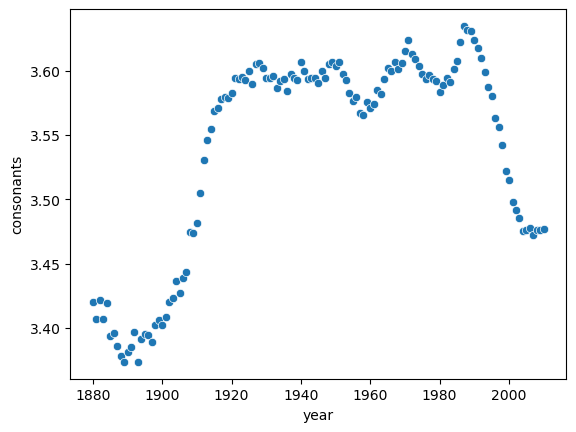

In [394]:
consonants_count_change = sn.scatterplot(data=year_tendencies, x = "year", y ="consonants")

__Анализ изменения средней длины слова__

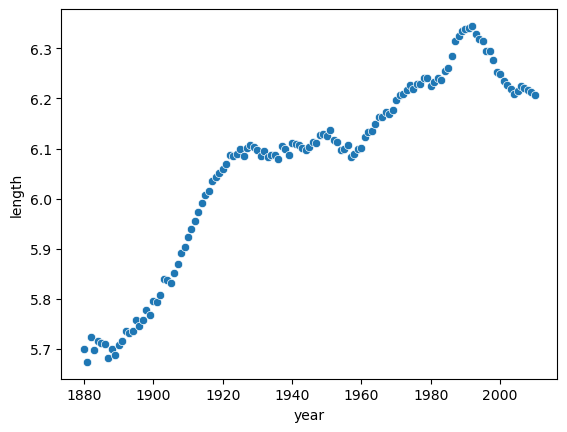

In [395]:
name_len_change = sn.scatterplot(data=year_tendencies, x = "year", y = "length")

__Анализ изменеия количества различных имён__

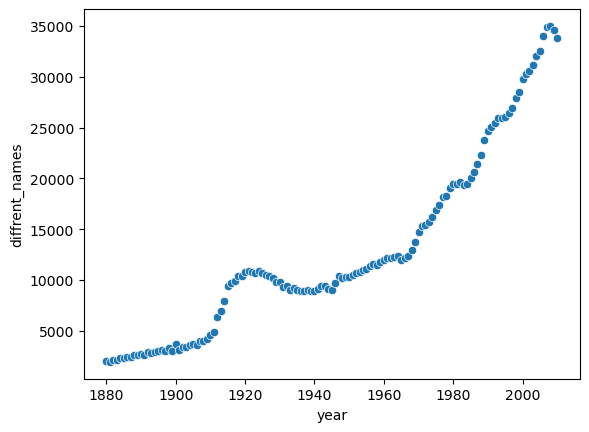

In [396]:
number_of_names_plot = sn.scatterplot(data=year_tendencies, x = "year", y = "diffrent_names")

__Анализ изменений предпочтений в выборе последнего и первого символа имен__

In [397]:
def get_dataset_made_changes(years: list[str], data_set: list[[list[str]]]) -> pd.DataFrame:
    """
    Creates dataframe that shows changes in set of symbols, 
    which where used in different position
    """
    year_with_changes = []
    changes = []
    for cur_year, cur_symbols, prev_symbols in zip(years[1:], data_set[1:], data_set):
        
        new_symbols = list(set(cur_symbols) - set(prev_symbols))
        new_symbols = ' '.join(['+' + new_symb for new_symb in new_symbols])

        unused_symbols = list(set(prev_symbols) - set(cur_symbols))
        unused_symbols = ' '.join(['-' + unused_symbol for unused_symbol in unused_symbols])

        if new_symbols or unused_symbols:
            year_with_changes.append(cur_year)
            changes.append(new_symbols + ' ' + unused_symbols)
    
    result = pd.DataFrame(data={'year': year_with_changes, 'changes': changes})
    return result


In [449]:
def get_dataset_symbol_usage(original: pd.DataFrame, proportion=True, symbol_index: int=0) -> pd.DataFrame:
    """
    Creates dataframe that shows proportion/count of names 
    that had this symbol on the given position
    """
    symbolsdf = original.drop('gender', axis=1)
    
    # Finding symbol use count in every year
    symbolsdf['name'] = symbolsdf['name'].apply(lambda x: x[symbol_index])
    symbolsdf = symbolsdf.groupby(['year', 'name']).agg({'count' : 'sum'})
    
    symbolsdf = symbolsdf.unstack(level=-1, fill_value=0)
    
    # Total number of babies in every year for counting proportion
    born_count = get_born_count(original)['count'].values
    
    if proportion:
        symbolsdf['count'] = symbolsdf['count'].apply(lambda x: x / born_count, axis=0)
    
    """
    #OLD code, result looks better, but much slower and uglier
    symbolsdf = original.drop('gender', axis=1)
    
    # Finding symbol use count in every year
    symbolsdf['name'] = symbolsdf['name'].apply(lambda x: x[symbol_index])
    symbolsdf = symbolsdf.groupby(['year', 'name']).agg({'count' : 'sum'})
    
    ALPHABET = string.ascii_uppercase if symbol_index == 0 else string.ascii_lowercase
    letter_data = {}
    
    # Total number of babies in every year for counting proportion
    born_count = get_born_count(original)['count'].values
    
    # Creating new dataframe with letters as columns and theirs count as value
    years = symbolsdf[['year']].drop_duplicates()
    
    # Filling every letter column with it's use count
    for letter in ALPHABET:
        years = years.merge(symbolsdf.query("name == @letter").drop('name', axis=1), how='left', on='year')
        years = years.rename(columns={"count" : letter})
        if proportion:
            years[letter] = years[letter].values / born_count
    
    return years.fillna(0)
    """
    return symbolsdf


__Анализ изменений в последних символах слов__

Начали использоваться новые симболы в конце имён: 'j', 'q'

In [450]:
get_dataset_made_changes(year_tendencies['year'].values, year_tendencies['last_symbols'].values)

,year,changes
0,1917,+j
1,1918,-j
2,1921,+j
3,1922,-j
4,1923,+j
5,1925,-j
6,1950,+j
7,1951,-j
8,1961,+j
9,1963,+q


Изменение количества использований буквы в конце имени

In [451]:
last_symbol_usage = get_dataset_symbol_usage(df, symbol_index=-1)
last_symbol_usage.head(10)

count                                                              \
name         a         b         c         d         e         f         g   
year                                                                         
1880  0.159922  0.002526  0.001732  0.048569  0.232627  0.000536  0.000764   
1881  0.167865  0.002439  0.001718  0.046673  0.241231  0.000431  0.000784   
1882  0.168409  0.002284  0.001598  0.047107  0.248319  0.000609  0.000713   
1883  0.180163  0.002083  0.001401  0.044277  0.253994  0.000489  0.000659   
1884  0.182765  0.002037  0.001310  0.044244  0.257638  0.000538  0.000756   
1885  0.191486  0.001831  0.001250  0.041834  0.264322  0.000477  0.000801   
1886  0.195341  0.001770  0.001108  0.041974  0.267735  0.000439  0.000623   
1887  0.200659  0.001754  0.001055  0.040664  0.273106  0.000501  0.000574   
1888  0.201213  0.001563  0.001018  0.039728  0.275450  0.000467  0.000781   
1889  0.205341  0.001346  0.000938  0.039940  0.280497  0.000429  0.000526   

                                                                       \
name         h         i    j         k         l         m         n   
year                                                                    
1880  0.044231  0.001295  0.0  0.023490  0.037874  0.056173  0.098950   
1881  0.044369  0.001474  0.0  0.021608  0.038827  0.053315  0.095458   
1882  0.043979  0.001300  0.0  0.021369  0.040417  0.051170  0.092892   
1883  0.044369  0.001120  0.0  0.020299  0.041244  0.047015  0.090821   
1884  0.044540  0.000994  0.0  0.019678  0.042766  0.044405  0.088982   
1885  0.044337  0.000992  0.0  0.019015  0.043644  0.041041  0.085166   
1886  0.043995  0.001003  0.0  0.018443  0.044414  0.039722  0.085468   
1887  0.044835  0.000986  0.0  0.017567  0.046618  0.037070  0.083292   
1888  0.044302  0.001075  0.0  0.017093  0.047838  0.035888  0.083866   
1889  0.045290  0.000997  0.0  0.015718  0.049955  0.033153  0.082745   

                                                                       \
name         o         p    q         r         s         t         u   
year                                                                    
1880  0.004779  0.001400  0.0  0.039382  0.098488  0.045169  0.002010   
1881  0.004406  0.001406  0.0  0.039906  0.091784  0.043554  0.002351   
1882  0.004338  0.001390  0.0  0.038720  0.089723  0.042792  0.001896   
1883  0.003959  0.001318  0.0  0.037566  0.084525  0.042903  0.002120   
1884  0.004161  0.001130  0.0  0.039845  0.081124  0.040388  0.002074   
1885  0.004347  0.001175  0.0  0.038815  0.077050  0.040401  0.002109   
1886  0.004148  0.001191  0.0  0.036636  0.075461  0.039033  0.002037   
1887  0.004329  0.001067  0.0  0.034479  0.071594  0.038299  0.001964   
1888  0.004574  0.001122  0.0  0.034325  0.069766  0.038773  0.001857   
1889  0.004385  0.000979  0.0  0.033202  0.066722  0.037303  0.001682   

                                                        
name         v         w         x         y         z  
year                                                    
1880  0.000164  0.004234  0.001509  0.093505  0.000670  
1881  0.000093  0.003908  0.001386  0.094482  0.000535  
1882  0.000194  0.003950  0.001602  0.094611  0.000618  
1883  0.000203  0.003660  0.001337  0.093771  0.000705  
1884  0.000148  0.003393  0.001409  0.094958  0.000719  
1885  0.000116  0.003247  0.001378  0.094471  0.000693  
1886  0.000125  0.003172  0.001379  0.093940  0.000842  
1887  0.000137  0.002785  0.001289  0.094521  0.000853  
1888  0.000100  0.002748  0.001439  0.094141  0.000871  
1889  0.000093  0.002620  0.001111  0.093951  0.001076

Анализ изменения доли слов заканчивающихся на некоторый символ

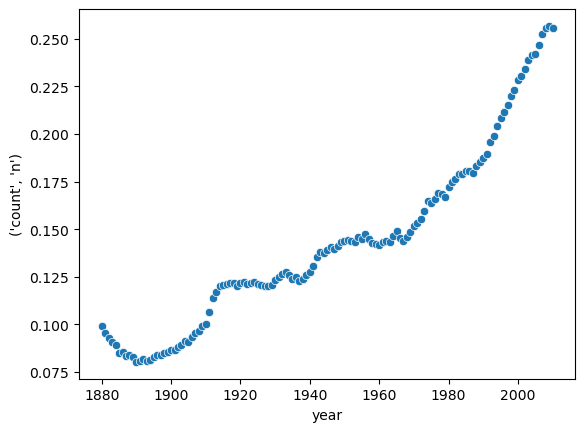

In [452]:
research_letter = "n"
last_symbol_plot = sn.scatterplot(data=last_symbol_usage, x = "year", y = ('count', research_letter))

__Анализ изменений в первых символах слов__

Появились дети, чьё имя начинается на букву 'X'

In [453]:
get_dataset_made_changes(year_tendencies['year'].values, year_tendencies['first_symbols'].values)

,year,changes
0,1886,+X
1,1887,-X
2,1890,+X
3,1891,-X
4,1894,+X
5,1898,-X
6,1907,+X
7,1908,-X
8,1912,+X


Изменение количества использований буквы в начале имени

In [454]:
first_symbol_usage = get_dataset_symbol_usage(df, symbol_index=0)
first_symbol_usage.head(10)

count                                                              \
name         A         B         C         D         E         F         G   
year                                                                         
1880  0.083083  0.029724  0.078502  0.023356  0.091014  0.047080  0.043363   
1881  0.084363  0.031167  0.076325  0.023181  0.094690  0.044483  0.043274   
1882  0.084816  0.032067  0.075224  0.022651  0.095916  0.045311  0.042729   
1883  0.086797  0.033579  0.076440  0.023198  0.098436  0.044461  0.041700   
1884  0.085835  0.034366  0.075013  0.022377  0.098630  0.044446  0.044014   
1885  0.085295  0.035523  0.075152  0.021810  0.101940  0.045043  0.043989   
1886  0.085578  0.035708  0.071940  0.021467  0.103230  0.045417  0.042425   
1887  0.087193  0.037325  0.071351  0.021516  0.105131  0.045373  0.041468   
1888  0.085673  0.038843  0.069943  0.021270  0.104695  0.045952  0.041554   
1889  0.086095  0.039670  0.069048  0.020972  0.107240  0.044851  0.040819   

                                                                            \
name         H         I         J         K         L         M         N   
year                                                                         
1880  0.051329  0.017009  0.129404  0.008040  0.063528  0.113879  0.019450   
1881  0.050067  0.017701  0.125198  0.008184  0.066268  0.115997  0.021001   
1882  0.049829  0.016792  0.121469  0.008378  0.067361  0.119140  0.019965   
1883  0.050034  0.017285  0.115416  0.008541  0.069632  0.122565  0.020972   
1884  0.049190  0.018150  0.112599  0.008556  0.068765  0.124329  0.020989   
1885  0.049033  0.017832  0.108529  0.009205  0.070490  0.126830  0.021702   
1886  0.048871  0.018435  0.106254  0.009243  0.071682  0.127768  0.022000   
1887  0.050567  0.018808  0.100645  0.009834  0.072358  0.131324  0.022337   
1888  0.052386  0.018912  0.098622  0.009339  0.072547  0.131221  0.021757   
1889  0.052523  0.019349  0.094370  0.009579  0.073716  0.134957  0.021837   

                                                                            \
name         O         P         Q         R         S         T         U   
year                                                                         
1880  0.013420  0.015286  0.000179  0.039000  0.033675  0.020185  0.000342   
1881  0.013518  0.015433  0.000150  0.039107  0.033710  0.018998  0.000296   
1882  0.013907  0.016164  0.000149  0.039975  0.033945  0.019315  0.000298   
1883  0.014492  0.015847  0.000106  0.039529  0.032744  0.018207  0.000249   
1884  0.014815  0.016557  0.000152  0.040991  0.032674  0.018311  0.000271   
1885  0.014502  0.016711  0.000158  0.041444  0.032451  0.016458  0.000403   
1886  0.015008  0.016837  0.000251  0.042029  0.032943  0.017194  0.000407   
1887  0.014734  0.017248  0.000158  0.041529  0.031981  0.016209  0.000420   
1888  0.014508  0.017283  0.000144  0.043451  0.032656  0.016101  0.000351   
1889  0.014812  0.016982  0.000194  0.044813  0.031811  0.015639  0.000429   

                                                       
name         V         W        X         Y         Z  
year                                                   
1880  0.006536  0.071310  0.00000  0.000159  0.001146  
1881  0.006907  0.068598  0.00000  0.000114  0.001271  
1882  0.007714  0.065510  0.00000  0.000068  0.001309  
1883  0.007619  0.060741  0.00000  0.000055  0.001355  
1884  0.008309  0.059010  0.00000  0.000086  0.001565  
1885  0.009142  0.054958  0.00000  0.000091  0.001312  
1886  0.009674  0.053896  0.00002  0.000110  0.001614  
1887  0.010004  0.050822  0.00000  0.000101  0.001564  
1888  0.010865  0.050005  0.00000  0.000093  0.001830  
1889  0.011341  0.047038  0.00000  0.000059  0.001858

Анализ изменения доли слов начинающихся с некоторого символа

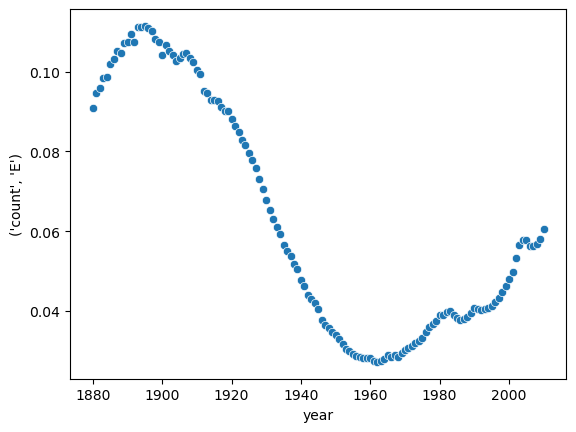

In [455]:
research_letter = 'E'
first_symbol_plot = sn.scatterplot(data=first_symbol_usage, x = 'year', y = ('count', research_letter))

### E) Анализ внешних источников тенденций

__Анализ имён знаменитостей__

In [456]:
def get_name_popularity_info(data_set: pd.DataFrame, name: str, years=[1880, 2010]) -> pd.DataFrame:
    """Creates dataframe that shows popularity of name on selected years"""
    
    df_without_gender = data_set.groupby(['name', 'year'], as_index=False).agg({'count': 'sum'})
    data_set = df_without_gender.query("@years[0] <= year <= @years[1] and name == @name").reset_index()
    
    total_names_count = (df_without_gender.query("@years[0] <= year <= @years[1]")
                        .groupby('year', as_index=False).agg({'count' : sum}))
    
    data_set['proportion'] = data_set['count'].values / total_names_count['count'].values
    
    return data_set[['year', 'name', 'count', 'proportion']]

__Elizabeth Taylor__

In [457]:
elizabeth_taylor_info = get_name_popularity_info(df, 'Elizabeth', years=[1940, 1970]) # Was popular actress 1950-1960
elizabeth_taylor_info.head()

,year,name,count,proportion
0,1940,Elizabeth,10008,0.004348
1,1941,Elizabeth,10317,0.004236
2,1942,Elizabeth,11231,0.004112
3,1943,Elizabeth,11683,0.004141
4,1944,Elizabeth,11068,0.004115


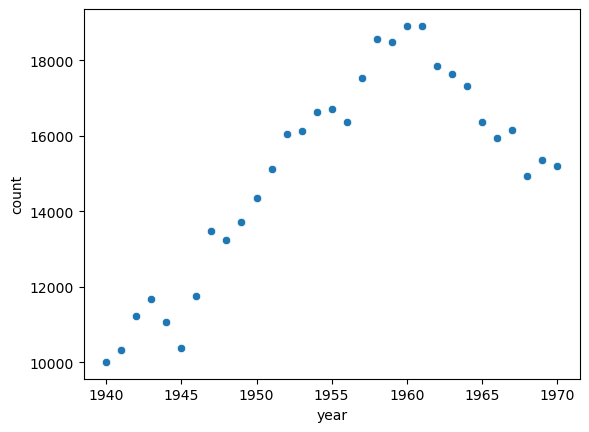

In [458]:
eliza_count_plot = sn.scatterplot(data=elizabeth_taylor_info, x = "year", y = "count") 

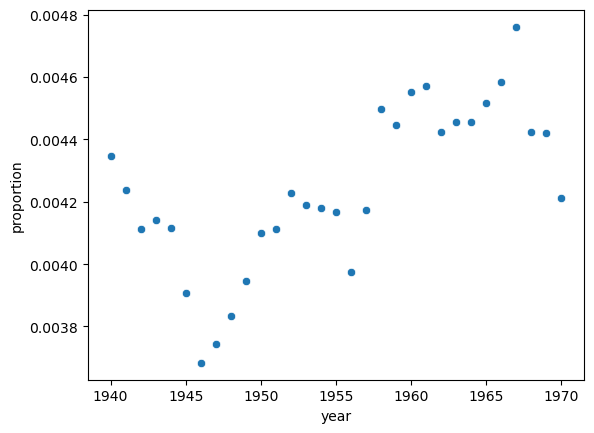

In [459]:
eliza_proportion_plot = sn.scatterplot(data=elizabeth_taylor_info, x = "year", y = "proportion") 

__John Wayne__

In [460]:
john_wayne_info = get_name_popularity_info(df, 'John', years=[1920, 1970]) # Got oscar in 1969 for a role in film "True Grit"
john_wayne_info.head()

,year,name,count,proportion
0,1920,John,57192,0.025276
1,1921,John,58512,0.025067
2,1922,John,57562,0.025145
3,1923,John,57805,0.025106
4,1924,John,59452,0.024964


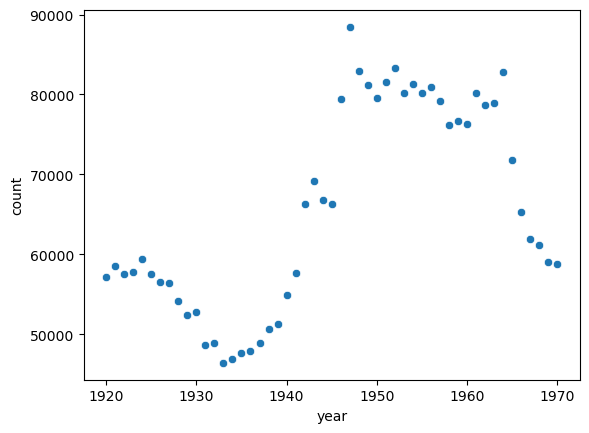

In [461]:
john_count_plot = sn.scatterplot(data=john_wayne_info, x = "year", y = "count") 

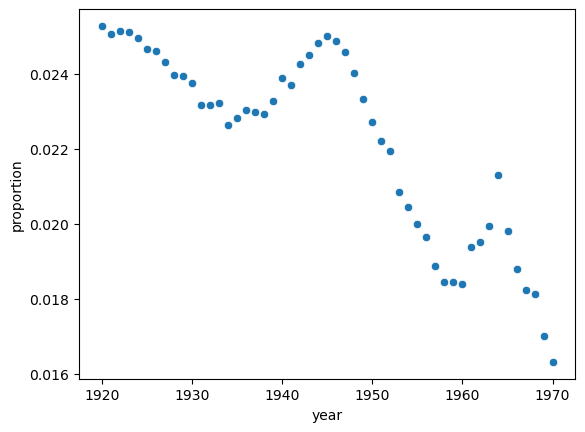

In [462]:
john_proportion_plot = sn.scatterplot(data=john_wayne_info, x = "year", y = "proportion")

__Rober Taylor__

In [463]:
robert_taylor_info = get_name_popularity_info(df, 'Robert', years=[1935, 1970])
# American actor, was one of the most famous actors in his time
robert_taylor_info.head() 

,year,name,count,proportion
0,1935,Robert,56732,0.027159
1,1936,Robert,58683,0.028257
2,1937,Robert,62022,0.029123
3,1938,Robert,62464,0.028243
4,1939,Robert,59832,0.027163


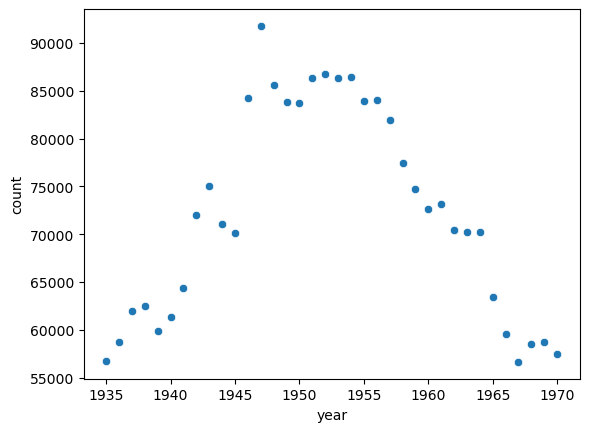

In [464]:
robert_count_plot = sn.scatterplot(data=robert_taylor_info, x = "year", y = "count")

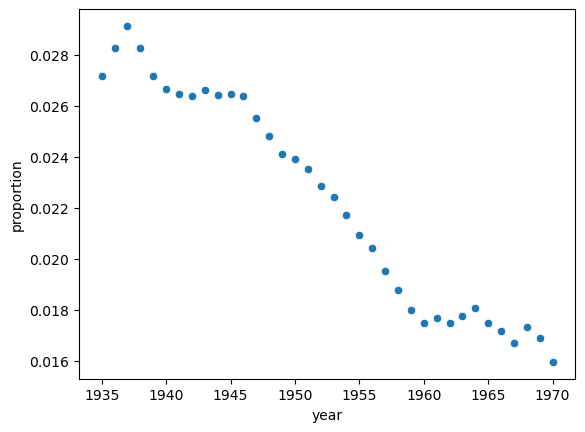

In [465]:
robert_proportion_plot = sn.scatterplot(data=robert_taylor_info, x = "year", y = "proportion")

__Анализ библейских имён__

__Jacob (Джеймс - Якоб)__

In [466]:
jacob_info = get_name_popularity_info(df, 'Jacob')

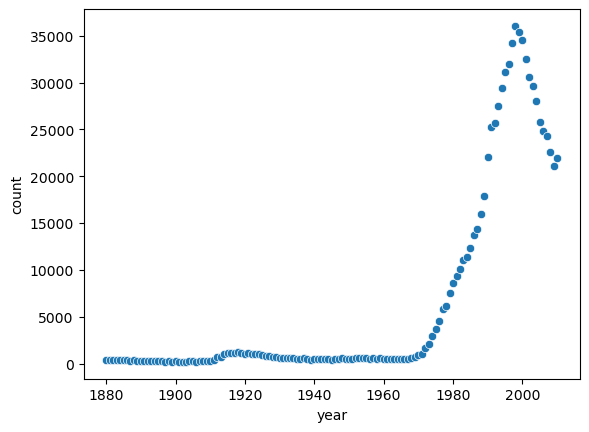

In [467]:
jacob_count_plot = sn.scatterplot(data=jacob_info, x = "year", y = "count")

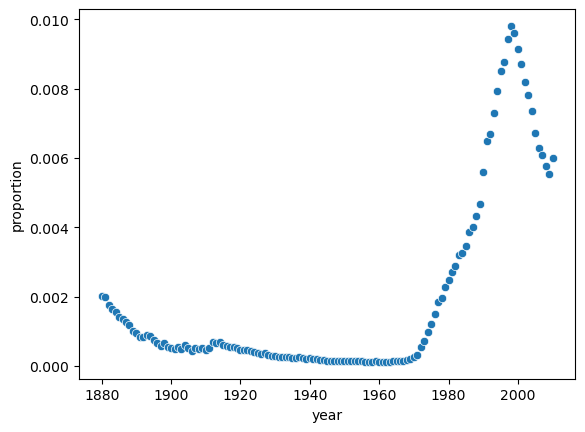

In [468]:
jacob_proportion_plot = sn.scatterplot(data=jacob_info, x = "year", y = "proportion")

__Mary (Мария)__

In [469]:
mary_info = get_name_popularity_info(df, 'Mary')

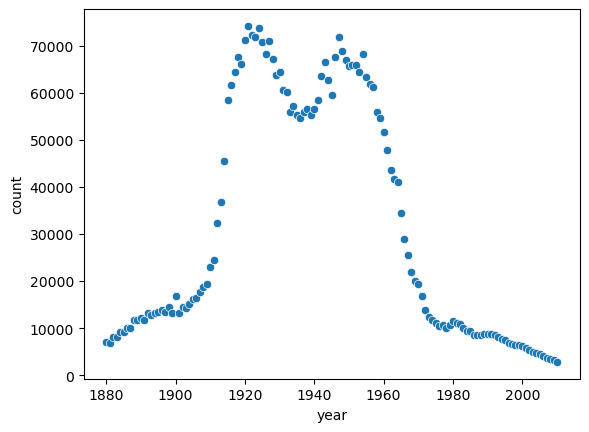

In [470]:
mary_count_plot = sn.scatterplot(data=mary_info, x = "year", y = "count")

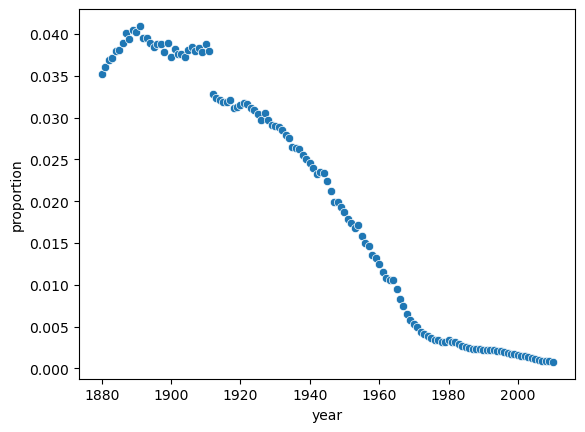

In [471]:
mary_proportion_plot = sn.scatterplot(data=mary_info, x = "year", y = "proportion")

__John (Иоанн)__

In [472]:
john_info = get_name_popularity_info(df, 'John')

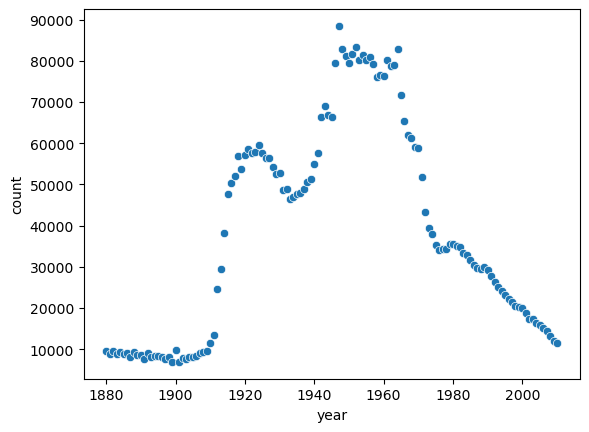

In [473]:
john_count_plot = sn.scatterplot(data=john_info, x = "year", y = "count")

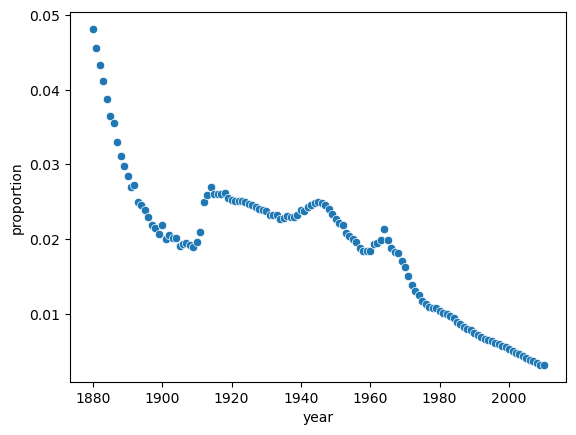

In [474]:
john_proportion_plot = sn.scatterplot(data=john_info, x = "year", y = "proportion")

__Влияние демографических событий на имена детей__

_Иммиграция в США. 1890-1920 годы
В Северную Америку перебрались жители регионов южной и восточной Европы. Преимущественно - жители Польши, Украины, России и Литвы._

__София__

In [475]:
sofia_info = get_name_popularity_info(df, 'Sofia', years=[1890, 1940])

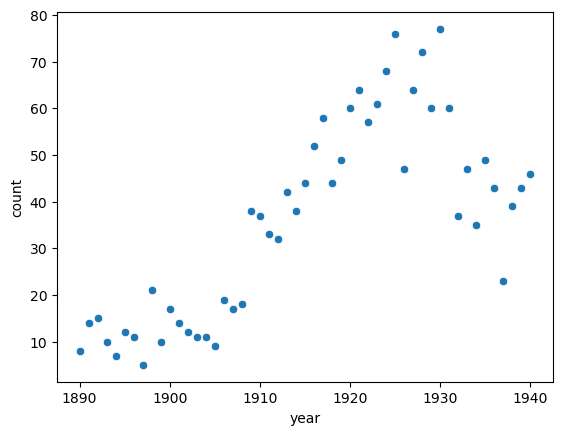

In [476]:
sofia_count_plot = sn.scatterplot(data=sofia_info, x = "year", y = "count")

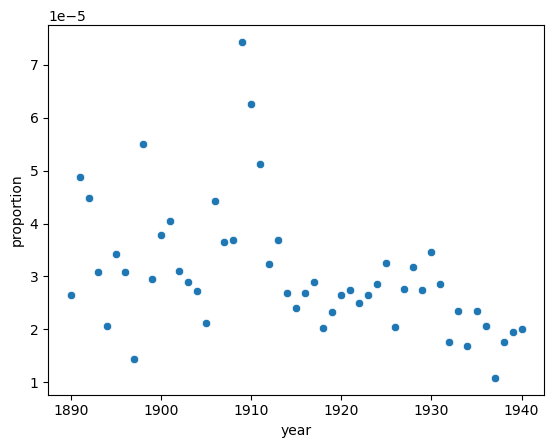

In [477]:
sofia_proportion_plot = sn.scatterplot(data=sofia_info, x = "year", y = "proportion")

__Анна__

In [478]:
anna_info = get_name_popularity_info(df, 'Anna', years=[1880, 1940])

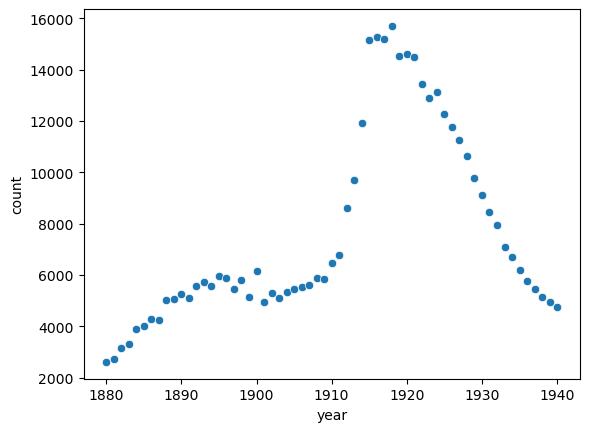

In [479]:
anna_count_plot = sn.scatterplot(data=anna_info, x = "year", y = "count")

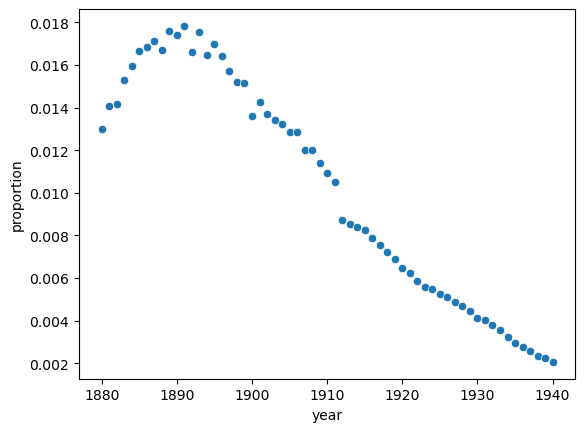

In [480]:
anna_proportion_plot = sn.scatterplot(data=anna_info, x = "year", y = "proportion")

__Иван__

In [481]:
ivan_info = get_name_popularity_info(df, 'Ivan', years=[1880, 1940])

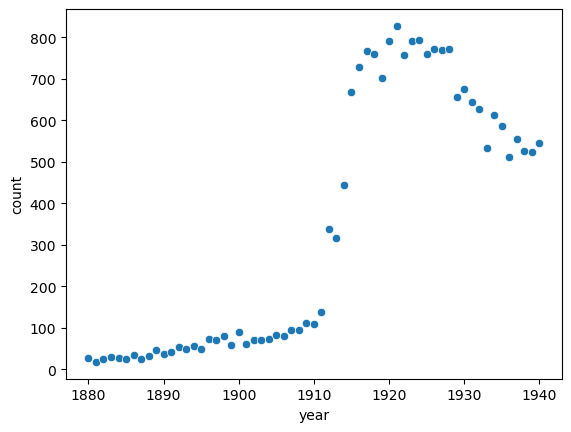

In [482]:
ivan_count_plot = sn.scatterplot(data=ivan_info, x = "year", y = "count")

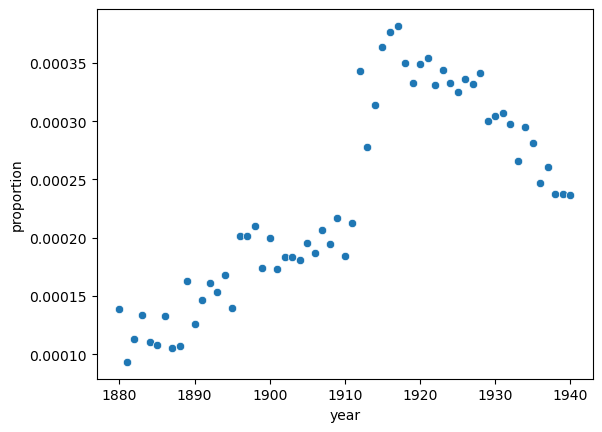

In [483]:
ivan_proportion_plot = sn.scatterplot(data=ivan_info, x = "year", y = "proportion")